# ACF summary

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gprot.summary import summarize_fits
from gprot.aigrain import AigrainTruths

df_acf_all = pd.read_table('../aigrain_acf.txt', delim_whitespace=True)
df_acf_all.index = df_acf_all['star']
# df_acf = df_acf.sort_values(['star', 'quality'], ascending=[True, False]).groupby('star').first()
# df_acf = df_acf.join(AigrainTruths().df)
# df_acf['P_MEAN'] = (df_acf.P_MIN + df_acf.P_MAX)/2.

In [2]:
from scipy.misc import logsumexp
from gprot.model import lnGauss

def lnp_density(x, subdf, width=0.1):
    return logsumexp(lnGauss(x, np.log(subdf.prot.values), width), b=subdf.quality.values)

def find_best(subdf):
    lnp = np.concatenate([np.arange(p-0.1, p+0.11, 0.01) for p in np.log(subdf.prot)])
    pdf = [lnp_density(p, subdf) for p in lnp]
    lnp_best = lnp[np.argmax(pdf)]
    i_best = np.argmin(np.absolute(np.log(subdf.prot.values) - lnp_best))
    return lnp_best, i_best

def select_acf_prots(df):
    """Tries to choose the best period out of candidate periods for each star
    """
    new_df = pd.DataFrame(columns=df.columns, index=np.unique(df.index))

    for ix in np.unique(df.index):
        debug = False
        
        subdf = df.ix[ix]

#         new_df.ix[ix] = subdf.sort_values('quality', ascending=False).iloc[0]
#         continue
        
        lnp_best, ibest = find_best(subdf)
        new_df.ix[ix] = subdf.iloc[ibest]
        new_df.ix[ix, 'prot'] = np.exp(lnp_best)
        
#         qbest = 0
#         taurat_best = 0
#         for i in range(len(subdf)):
#             q = subdf.quality.iloc[i]
#             tau = subdf.tau.iloc[i]
#             prot = subdf.prot.iloc[i]
#             taurat = tau/prot
#             if debug:
#                 print(i, q, taurat)
#             if q > qbest: 
#                 qbest = q
#                 ibest = i
#                 if debug:
#                     print('best: {}, {}, {}'.format(ibest, qbest, taurat_best))
#         new_df.ix[ix] = subdf.iloc[ibest]
    
    new_df.prot = new_df.prot.astype(float)
    new_df.height = new_df.height.astype(float)
    new_df.tau = new_df.tau.astype(float)
    new_df.quality = new_df.quality.astype(float)
    return new_df

df_acf = select_acf_prots(df_acf_all)
df_acf = df_acf.join(AigrainTruths().df)
df_acf['P_MEAN'] = (df_acf.P_MIN + df_acf.P_MAX)/2.
df_acf['good'] = np.abs((df_acf.prot - df_acf.P_MEAN) / df_acf.P_MEAN) < 0.2

/Users/tdm/anaconda/lib/python2.7/site-packages/scipy/misc/common.py:131: RuntimeWarning: invalid value encountered in log
  out = log(s)


In [3]:
df_acf_all = df_acf_all.join(AigrainTruths().df)
df_acf_all['P_MEAN'] = (df_acf_all['P_MIN'] + df_acf_all['P_MAX'])/2.
df_acf_all['good'] = np.abs((df_acf_all.prot - df_acf_all.P_MEAN) / df_acf_all.P_MEAN) < 0.2

In [4]:
cols = ['pmax', 'prot', 'height', 'tau', 'quality', 'P_MEAN','TAU', 'good']
subdf = df_acf_all[cols].ix[50]
subdf

,pmax,prot,height,tau,quality,P_MEAN,TAU,good
50,1,0.818,0.098,0.025,3.06,33.0,1.37,False
50,3,3.005,0.086,0.162,6.63,33.0,1.37,False
50,5,4.374,0.090,1.348,64.61,33.0,1.37,False
50,10,16.209,0.173,4.644,15.87,33.0,1.37,False
50,30,31.580,0.746,29.224,35.81,33.0,1.37,True
50,50,32.111,0.670,33.896,60.05,33.0,1.37,True
50,100,32.152,0.424,25.301,43.06,33.0,1.37,True


67 good, 674 bad


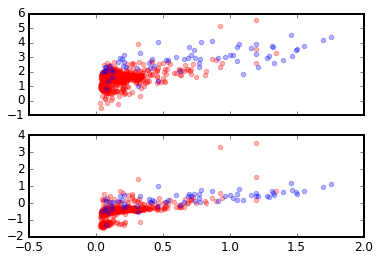

In [5]:
good5 = df_acf_all.query('pmax==5 and good')
nogood5 = df_acf_all.query('pmax==5 and not good and height > 0')

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
ax1.scatter(nogood5.height, np.log10(nogood5.quality), label='not good', color='r', alpha=0.3);
ax1.scatter(good5.height, np.log10(good5.quality), label='good', color='b', alpha=0.3) 
ax2.scatter(nogood5.height, np.log10(nogood5.tau/nogood5.prot), label='not good', color='r', alpha=0.3);
ax2.scatter(good5.height, np.log10(good5.tau/good5.prot), label='good', color='b', alpha=0.3) 
print('{} good, {} bad'.format(len(good5), len(nogood5)))
# plt.legend();

In [7]:
df_acf.columns

Index([u'star', u'pmax', u'prot', u'height', u'tau', u'quality', u'N', u'AR',
       u'CLEN', u'COVER', u'LMIN', u'LMAX', u'R', u'SINI', u'PEQ', u'PPOL',
       u'A_MED', u'TAU', u'NSPOT', u'DELTA_OMEGA', u'DELTA_OMEGA_REL',
       u'OMEGA_EQ', u'OMEGA_POL', u'OMEGA_MIN', u'OMEGA_MAX', u'P_MIN',
       u'P_MAX', u'AMP', u'KID', u'P_MEAN', u'good'],
      dtype='object')

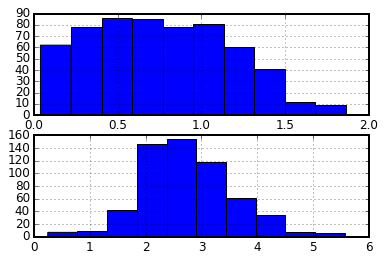

In [19]:
ok = np.isfinite(df_acf.prot) & np.isfinite(df_acf.height)
fig, axes = plt.subplots(2, 1)
df_acf.height[ok].hist(ax=axes[0]);
df_acf.quality[ok].apply(np.log10).hist(ax=axes[1]);

(296, 1000)


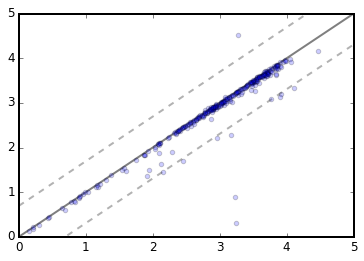

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import mpld3
from mpld3 import plugins
mpld3.enable_notebook()

# q = 'tau > 0.5*prot and DELTA_OMEGA==0'
# q = 'DELTA_OMEGA==0' # & quality > 50'
q = 'quality > 400 & height > 0.4'

fig, ax = plt.subplots(1,1)
points = ax.scatter(np.log(df_acf.query(q)['P_MEAN']), np.log(df_acf.query(q).prot), 
                    alpha=0.2)
ax.plot(range(6), range(6), 'k', lw=2, alpha=0.5, zorder=0)
ax.plot(range(6), np.arange(6) + np.log(2), ls='--', c='k', alpha=0.3)
ax.plot(range(6), np.arange(6) - np.log(2), ls='--', c='k', alpha=0.3)
ax.set_xlim((0,5))
ax.set_ylim((0,5))
tooltip = plugins.PointLabelTooltip(points, labels=['{}: {:.2f} ({:.2f})'.format(i, df_acf.ix[i, 'P_MEAN'],
                                                                                 df_acf.ix[i, 'prot'])
                                                    for i in df_acf.query(q).index])
plugins.connect(fig, tooltip)
print(len(df_acf.query(q)), len(df_acf))

In [14]:
# Features: pmax, prot, height, tau, quality
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm

Classifier = RandomForestClassifier
kwargs = dict(n_estimators=20)
# Classifier = svm.SVC
# kwargs = dict(C=10.0, cache_size=100, class_weight=None, coef0=0.0,
#     decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
#     max_iter=-1, probability=True, random_state=None, shrinking=True,
#     tol=0.001, verbose=False)

def transform_X(Xin):
    X = Xin.copy()
    X['pmax'] /= Xin['pmax'].max()
    X['prot'] /= Xin['prot'].max()
    X['height'] /= Xin['height'].max()
    X['taurat'] /= Xin['taurat'].quantile(0.9)
    X['quality'] /= Xin['quality'].quantile(0.9)
    for col in X.columns:
        if col not in ['pmax', 'prot', 'height', 'taurat', 'quality']:
            del X[col]
    return X

df_ok = df_acf_all[['pmax', 'prot', 'height', 'tau', 'quality', 'good', 'P_MEAN']].dropna()
X = df_ok[['pmax', 'prot', 'height', 'quality']]
X['taurat'] = df_ok['tau']/df_ok['prot']
X = transform_X(X)
y = df_ok['good']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

clf = Classifier(**kwargs)
clf = clf.fit(X_train, y_train)

/Users/tdm/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
clf.score(X_test, y_test)

0.92038216560509556

In [16]:
df_acf_all['taurat'] = df_acf_all['tau'] / df_acf_all['prot']
X_all = transform_X(df_acf_all.dropna())
ypred = clf.predict(X_all)

In [17]:
ok = np.logical_not(df_acf_all.isnull().any(axis=1))

In [18]:
good_pred = np.zeros(len(df_acf_all), dtype=bool)
good_pred[np.where(ok)] = ypred
df_acf_all['good_pred'] = good_pred

In [20]:
df_acf_all.ix[50, cols + ['good_pred']]

,pmax,prot,height,tau,quality,P_MEAN,TAU,good,good_pred
50,1,0.818,0.098,0.025,3.06,33.0,1.37,False,False
50,3,3.005,0.086,0.162,6.63,33.0,1.37,False,False
50,5,4.374,0.090,1.348,64.61,33.0,1.37,False,False
50,10,16.209,0.173,4.644,15.87,33.0,1.37,False,False
50,30,31.580,0.746,29.224,35.81,33.0,1.37,True,True
50,50,32.111,0.670,33.896,60.05,33.0,1.37,True,True
50,100,32.152,0.424,25.301,43.06,33.0,1.37,True,True


In [152]:
len(df_acf_all.query('good_pred != good')), len(df_acf_all)

(113, 6000)

In [162]:
bad = df_acf_all[cols].isnull().any(axis=1)
df_acf_all[bad]

,star,pmax,prot,height,tau,quality,N,AR,CLEN,COVER,...,OMEGA_MIN,OMEGA_MAX,P_MIN,P_MAX,AMP,KID,P_MEAN,good,taurat,good_pred
33,33,10,NaN,-inf,NaN,NaN,33,0.475,4.589,0.260,...,0.246039,0.343579,18.287478,25.537348,0.001744,3112917,21.912413,False,NaN,False
129,129,10,NaN,-inf,NaN,NaN,129,0.995,5.958,0.388,...,0.174630,0.174630,35.980000,35.980000,0.014651,4732026,35.980000,False,NaN,False
466,466,20,NaN,-inf,NaN,NaN,466,1.008,3.907,1.698,...,0.138366,0.138366,45.410000,45.410000,0.004441,8078451,45.410000,False,NaN,False
849,849,20,NaN,-inf,NaN,NaN,849,0.623,3.564,1.976,...,0.132719,0.143990,43.636386,47.342110,0.012531,0,45.489248,False,NaN,False
886,886,5,NaN,-inf,NaN,NaN,886,0.481,4.404,0.872,...,0.601838,0.601838,10.440000,10.440000,0.000972,0,10.440000,False,NaN,False
893,893,5,NaN,-inf,NaN,NaN,893,0.828,3.260,0.242,...,0.567942,0.604484,10.394304,11.063078,0.004349,0,10.728691,False,NaN,False
897,897,5,NaN,-inf,NaN,NaN,897,1.460,1.269,1.409,...,0.538615,0.574927,10.928664,11.665437,0.009419,0,11.297051,False,NaN,False
912,912,5,NaN,-inf,NaN,NaN,912,3.099,9.581,0.261,...,0.547316,0.547316,11.480000,11.480000,0.007607,0,11.480000,False,NaN,False
937,937,10,NaN,-inf,NaN,NaN,937,0.349,1.472,0.166,...,0.281553,0.326785,19.227299,22.316200,0.001240,0,20.771750,False,NaN,False
947,947,10,NaN,-inf,NaN,NaN,947,0.504,2.831,2.495,...,0.290071,0.325563,19.299444,21.660830,0.003401,0,20.480137,False,NaN,False


In [149]:
df_acf_all.query('good_pred != good')[cols + ['good_pred']]

,pmax,prot,height,tau,quality,P_MEAN,TAU,good,good_pred
4,60,56.659,0.235,68.146,251.90,71.997368,2.39,False,True
21,100,35.484,0.061,6.407,23.50,46.528002,3.68,False,True
34,40,33.623,0.390,22.036,136.13,20.074391,1.02,False,True
50,20,16.802,0.607,20.412,65.58,33.000000,1.37,False,True
72,20,13.327,0.485,8.383,95.54,32.314141,3.00,False,True
78,20,18.498,0.580,13.320,62.27,22.551764,1.37,True,False
79,20,16.577,0.666,20.260,216.16,23.895332,6.82,False,True
79,60,17.496,0.525,47.089,99.76,23.895332,6.82,False,True
102,100,33.828,0.039,6.315,6.12,35.520528,5.53,True,False
121,60,51.611,0.127,15.257,69.71,52.846506,1.80,True,False


# MCMC results

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gprot.summary import summarize_fits
from gprot.aigrain import AigrainTruths

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import mpld3
from mpld3 import plugins
mpld3.enable_notebook()

# resultsdir = '../results_noprior'
resultsdir = '../results'
df = summarize_fits(resultsdir, truths='aigrain')
df = df.join(AigrainTruths().df)
df['P_MEAN'] = (df.P_MIN + df.P_MAX)/2.

q = 'DELTA_OMEGA==0'
df = df.query(q)
print(len(df))
# m = df.ln_G_50 < 5
# df = df[m]

333


/Users/tdm/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/tdm/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


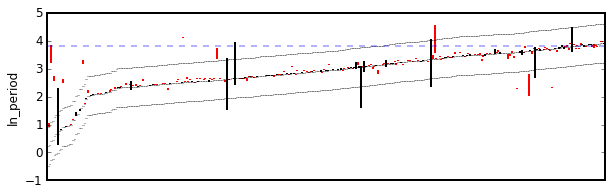

In [2]:
inds = df.index[np.argsort(df.aigrain_p_mean)]
fig, ax = plt.subplots(1, 1, figsize=(10,3))
lines = []
labels = []
colors = []
ln2 = np.log(2)
di = 0.5
bad_shortP = []
bad_longP = []
highlight = []
good_fits = []
for i,ix in enumerate(inds):
    ymin, ymax = df.ix[ix, ['aigrain_p_min', 'aigrain_p_max']]
    ymean = (ymin + ymax)/2.
    ax.plot([i,i], [ymin, ymax], color='k', alpha=0.2)
    ax.plot([i-di, i+di], [ymean, ymean], color='k', lw=1, alpha=0.3)
    ax.plot([i-di, i+di], [ymean-ln2, ymean-ln2], color='k', lw=1, alpha=0.3)
    ax.plot([i-di, i+di], [ymean+ln2, ymean+ln2], color='k', lw=1, alpha=0.3)
#     tau, peq = df.ix[ix, ['TAU', 'PEQ']]
#     y_tau = np.log(tau*peq)
#     ax.plot([i-0.5, i+1.5], [y_tau, y_tau], color='k', lw=1)
    
    
    ylo, yhi = df.ix[ix, ['ln_period_16', 'ln_period_84']]
    if ix in highlight:
        color = 'b'
    elif (yhi < ymin) or (ylo > ymax):
        color='r'
        if yhi < ymin:
            bad_longP.append(ix)
        else:
            bad_shortP.append(ix)
    else:
        if yhi - ylo < 0.2:
            good_fits.append(ix)
        color='k'
    lines.append(([i,ylo], [i,yhi]))
    colors.append(color)
    label = '{}: AMP={:.2e}'.format(ix, df.ix[ix, 'AMP'])
    labels.append(label)

collection = LineCollection(lines, colors=colors, linewidths=2)
ax.add_collection(collection)
ax.set_xlim((-0.5, i+0.5))
ax.set_xticks([]);
ax.set_ylabel('ln_period');
ax.plot([-0.5, i+0.5], [np.log(45), np.log(45)], ls='--', color='b', alpha=0.3);

tooltip = mpld3.plugins.PointLabelTooltip(collection, labels=labels)
plugins.connect(fig, tooltip)

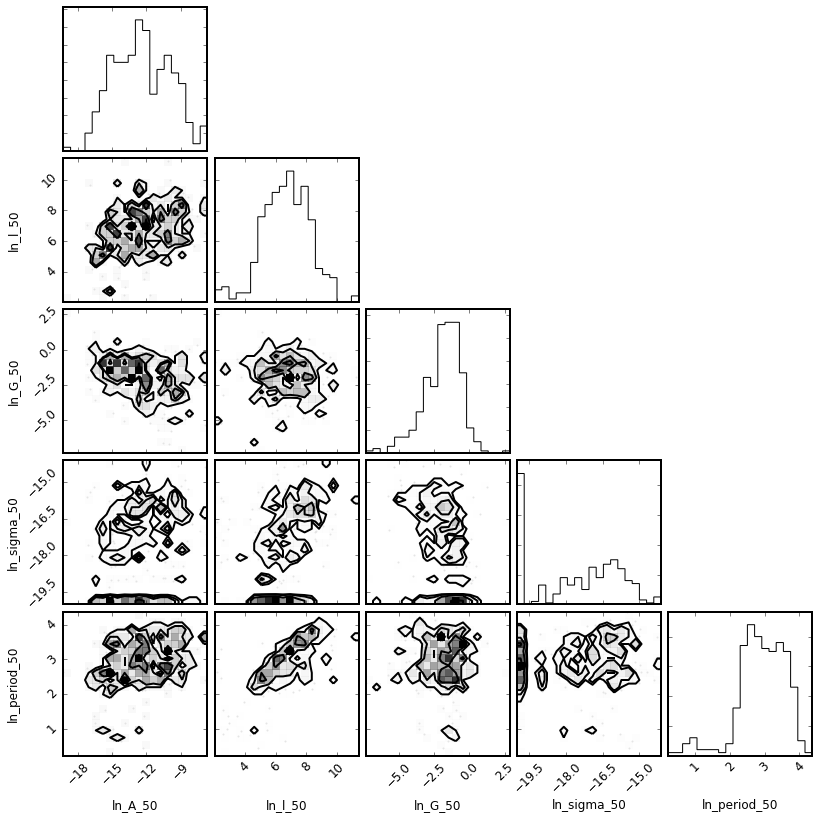

In [3]:
import corner
cols = ['ln_A_50', 'ln_l_50', 'ln_G_50', 'ln_sigma_50', 'ln_period_50']
mpld3.disable_notebook()
corner.corner(df[cols], labels=cols);

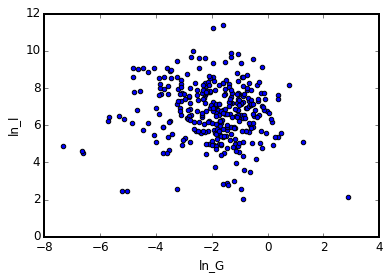

In [4]:
mpld3.enable_notebook()
plt.scatter(df.ln_G_50, df.ln_l_50);
plt.xlabel('ln_G')
plt.ylabel('ln_l');

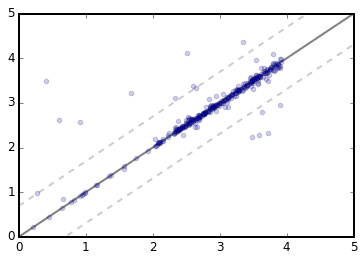

In [5]:
fig, ax = plt.subplots(1,1)
points = ax.scatter(df.aigrain_p_mean, df.ln_period_50, alpha=0.2)
ax.plot(range(6), range(6), 'k', lw=2, alpha=0.5, zorder=0)
ax.plot(range(6), range(6) + np.log(2), 'k', ls='--', lw=2, alpha=0.2, zorder=0)
ax.plot(range(6), range(6) - np.log(2), 'k', ls='--', lw=2, alpha=0.2, zorder=0)
ax.set_xlim((0,5))
ax.set_ylim((0,5))
tooltip = plugins.PointLabelTooltip(points, labels=['{}: {:.2f} ({:.2f})'.format(i, df.ix[i, 'P_MEAN'],
                                                                                 np.exp(df.ix[i, 'ln_period_50']))
                                                    for i in df.index])
plugins.connect(fig, tooltip)

In [15]:
q = 'ln_period_84 > ln_l_16'
df.query(q)[['ln_l_16','ln_l_50','ln_l_84',
             'ln_period_16','ln_period_50', 'ln_period_84']]

,ln_l_16,ln_l_50,ln_l_84,ln_period_16,ln_period_50,ln_period_84
150,2.305561,2.587462,2.783030,0.277760,0.842681,2.325571
335,2.128759,2.403071,2.483330,2.099645,3.157509,3.903116
337,2.337881,2.471484,2.721392,1.531119,2.461018,3.383000
405,3.287731,5.102308,6.711402,3.216200,3.479293,3.855531
762,2.053974,2.141305,2.294506,2.529483,2.618162,2.761445


In [28]:
i = 279
print(np.log(truth.ix[i, ['P_MIN','P_MAX']]))
print(df.ix[i, ['ln_period_16', 'ln_period_84']])

P_MIN    3.905804
P_MAX    3.905804
Name: 279, dtype: float64
ln_period_16    2.601855
ln_period_84    2.651217
Name: 279, dtype: float64


In [30]:
np.exp(3.906)

49.699754825406366

In [31]:
from gprot.lc import qtr_times
qtr_times

,tstart,tstop
q,,
1,131.511880,164.983257
2,169.518900,258.466998
3,260.223736,349.494411
4,352.376612,442.202053
5,443.489554,538.161241
6,539.449771,629.295934
7,630.174122,719.547036
8,735.362357,802.343677
9,808.515159,905.926044
